# CNN Hyperparameter Search - Analysis
### This notebook documents the analysis of the hyperparamter search

In [18]:
%matplotlib inline

import matplotlib.pyplot as plt
import pickle
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, LabelBinarizer
from sklearn.model_selection import StratifiedKFold
import annsa as an
import tensorflow as tf
import tensorflow.contrib.eager as tfe
from random import choice
import glob

In [19]:
def read_final_errors(file_path, *args): 

    final_errors = []
    for model_id in args:
        final_errors = np.append(final_errors, np.load(file_path+model_id+'.npy'))
    return final_errors

In [20]:
class all_cnn_errors_class(object):

    def __init__(self,
                 cnn_filters,
                 cnn_kernel,
                 cnn_strides,
                 pool_size,
                 pool_strides,
                 dropout_probability,
                 batch_size,
                 learining_rate,
                 dense_nodes,
                 activation_function,
                 l2_regularization_scale,
                 cnn_filters_length,
                 cnn_kernel_length,
                 pool_size_length,
                 pool_strides_length,
                 dense_nodes_length,
                 dense_nodes_total,
                 normalizer,
                 scaling,
                 ):

        self.cnn_filters = cnn_filters
        self.cnn_kernel = cnn_kernel
        self.cnn_strides = cnn_strides
        self.pool_size = pool_size
        self.pool_strides = pool_strides
        self.dropout_probability = dropout_probability
        self.batch_size = batch_size
        self.learining_rate = learining_rate
        self.dense_nodes = dense_nodes
        self.activation_function = activation_function
        self.l2_regularization_scale = l2_regularization_scale
        self.cnn_filters_length = cnn_filters_length
        self.cnn_kernel_length = cnn_kernel_length
        self.pool_size_length = pool_size_length
        self.pool_strides_length = pool_strides_length
        self.dense_nodes_length = dense_nodes_length
        self.dense_nodes_total = dense_nodes_total
        self.normalizer = normalizer
        self.scaling = scaling


In [30]:
def read_cnn_errors_and_features(file_path_errors, model_id, *args):

    all_errors = read_final_errors(file_path_errors, *args)

    cnn_filters = []
    cnn_kernel = []
    cnn_strides = []
    pool_size = []
    pool_strides = []
    dropout_probability = []
    batch_size = []
    learining_rate = []
    dense_nodes = []
    activation_function = []
    l2_regularization_scale = []
    scaling = []
    normalizer = []
    
    for j in range(len(args)):
        total_errors = len(np.load(file_path_errors+args[j]+'.npy'))
        j = '-'+str(j)
        total_models = len(glob.glob('../hyperparameter_search/hyperparameter-search-results/'+model_id+j+'*'))
        for i in range(0, total_errors):

            i = '_'+str(i)
            
            with open('../hyperparameter_search/hyperparameter-search-results/'+model_id+j+i,"rb" ) as f:

                model_features = pickle.load(f)
                scaling_tmp, normalizer_tmp = read_scaler_pipeline(model_features.scaler)

                scaling.append(scaling_tmp)
                normalizer.append(normalizer_tmp)
                cnn_filters.append(model_features.cnn_filters)
                cnn_kernel.append(model_features.cnn_kernel)
                cnn_strides.append(model_features.cnn_strides)
                pool_size.append(model_features.pool_size)
                pool_strides.append(model_features.pool_strides)
                learining_rate.append(model_features.learining_rate)

                dropout_probability.append(model_features.dropout_probability)
                batch_size.append(model_features.batch_size)
                dense_nodes.append(model_features.dense_nodes)
                l2_regularization_scale.append(model_features.l2_regularization_scale)
                activation_function.append(model_features.activation_function)

    for i in range(len(activation_function)):
        if 'relu' in str(activation_function[i]):
            activation_function[i] = 'relu'
        if 'sigmoid' in str(activation_function[i]):
            activation_function[i] = 'sigmoid'
        if 'tanh' in str(activation_function[i]):
            activation_function[i] = 'tanh'


    cnn_filters_length = [len(feature) for feature in cnn_filters]
    cnn_kernel_length = [feature[0] for feature in cnn_kernel]
    pool_size_length = [feature[0] for feature in pool_size]
    pool_strides_length = [feature[0] for feature in pool_strides]
    dense_nodes_length = [len(feature) for feature in dense_nodes]
    dense_nodes_total = [sum(feature) for feature in dense_nodes]    

    all_features = all_cnn_errors_class(cnn_filters,
                                       cnn_kernel,
                                       cnn_strides,
                                       pool_size,
                                       pool_strides,
                                       dropout_probability,
                                       batch_size,
                                       learining_rate,
                                       dense_nodes,
                                       activation_function,
                                       l2_regularization_scale,
                                       cnn_filters_length,
                                       cnn_kernel_length,
                                       pool_size_length,
                                       pool_strides_length,
                                       dense_nodes_length,
                                       dense_nodes_total,
                                       normalizer,
                                       scaling,)

    return all_errors, all_features


In [31]:
def read_scaler_pipeline(scaler):
    
    scaling = scaler.named_steps['functiontransformer'].func.__name__
    
    normalizer = 'None'    
    if scaler.named_steps.get('normalizer'):
        normalizer = scaler.named_steps['normalizer'].norm

    return scaling, normalizer


## Load easy errors

In [44]:
file_path_errors = '../hyperparameter_search/final-models/final_test_errors_'

In [45]:
data_strings_easy = ['CNN-kfoldseasy-final-'+str(x) for x in range(10)]

In [46]:
cnn_errors_easy, all_features_easy = read_cnn_errors_and_features(file_path_errors,
                                                                  'CNN-kfoldseasy-final',
                                                                  *data_strings_easy,
                                                                 )

## Load full errors

In [47]:
data_strings_full = ['CNN-kfoldsfull-final-'+str(x) for x in range(10)]

In [48]:
cnn_errors_full, all_features_full = read_cnn_errors_and_features(file_path_errors,
                                                                  'CNN-kfoldsfull-final',
                                                                  *data_strings_full,
                                                                  )

# Batch size

In [49]:
print(len(all_features_easy.batch_size))
print(len(cnn_errors_easy))
print('\n')
print(len(all_features_full.batch_size))
print(len(cnn_errors_full))

305
305


323
323


Text(0.5,0,'F1 Error')

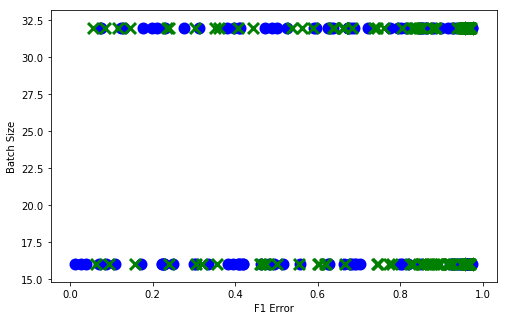

In [50]:
alpha = 1.0
linewidth = 3
size = 80

plt.figure(figsize=(8,5))
plt.scatter(cnn_errors_easy, all_features_easy.batch_size, c='b', alpha=alpha, s=size, linewidth=linewidth)
plt.scatter(cnn_errors_full, all_features_full.batch_size, c='g', alpha=alpha, s=1.5*size, marker='x', linewidth=linewidth)
plt.ylabel('Batch Size')
plt.xlabel('F1 Error')


# Learning Rate

Text(0.5,0,'F1 Error')

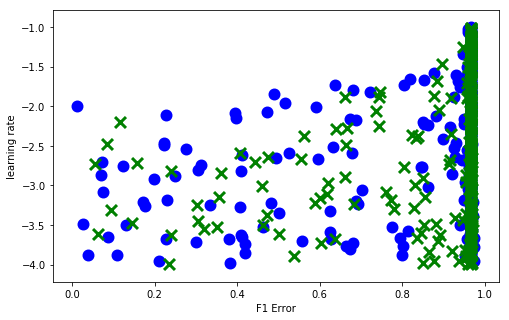

In [51]:
plt.figure(figsize=(8,5))
plt.scatter(cnn_errors_easy, np.log10(all_features_easy.learining_rate), c='b', alpha=alpha, s=size, linewidth=linewidth)
plt.scatter(cnn_errors_full, np.log10(all_features_full.learining_rate), c='g', alpha=alpha, s=1.5*size, marker='x', linewidth=linewidth)
plt.ylabel('learning rate')
plt.xlabel('F1 Error')

# Similar to the dense networks, it is likely best to keep the learning rate below 1e-2.5 for CNN applications
# to gamma-ray spectroscopy.

# Dropout probability

Text(0.5,0,'F1 Error')

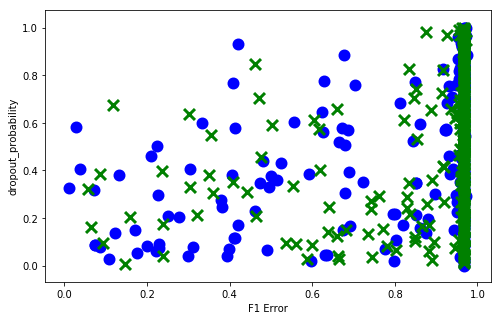

In [52]:
plt.figure(figsize=(8,5))

plt.scatter(cnn_errors_easy, all_features_easy.dropout_probability, c='b', alpha=alpha, s=size, linewidth=linewidth)
plt.scatter(cnn_errors_full, all_features_full.dropout_probability, c='g', alpha=alpha, s=1.5*size, marker='x', linewidth=linewidth)

plt.ylabel('dropout_probability')
plt.xlabel('F1 Error')

# It is best to keep the dropout probability below 0.4. 

# Total dense nodes

Text(0.5,0,'F1 Error')

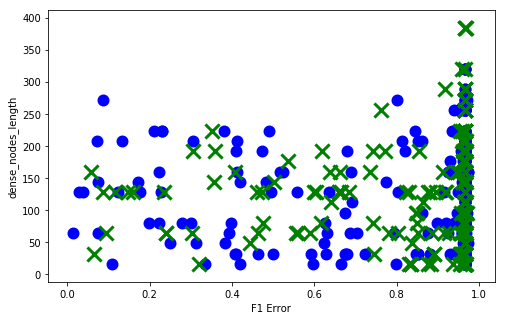

In [53]:
plt.figure(figsize=(8,5))

plt.scatter(cnn_errors_easy, all_features_easy.dense_nodes_total, c='b', alpha=alpha, s=size, linewidth=linewidth)
plt.scatter(cnn_errors_full, all_features_full.dense_nodes_total, c='g', alpha=alpha, s=2.5*size, marker='x', linewidth=linewidth)

plt.ylabel('dense_nodes_length')
plt.xlabel('F1 Error')

# L2 regularization

Text(0.5,0,'F1 Error')

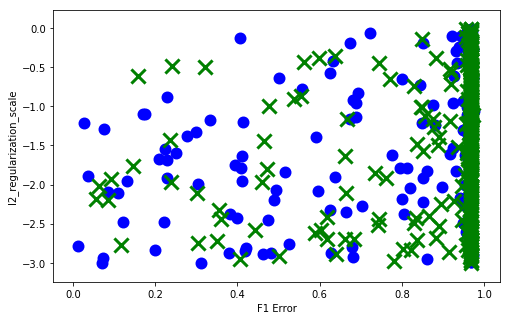

In [54]:
plt.figure(figsize=(8,5))

plt.scatter(cnn_errors_easy, np.log10(all_features_easy.l2_regularization_scale), c='b', alpha=alpha, s=size, linewidth=linewidth)
plt.scatter(cnn_errors_full, np.log10(all_features_full.l2_regularization_scale), c='g', alpha=alpha, s=2.5*size, marker='x', linewidth=linewidth)

plt.ylabel('l2_regularization_scale')
plt.xlabel('F1 Error')

# A small regularization term should be added to the dense network for a CNN.

# CNN number of convolution layers

Text(0.5,0,'F1 Error')

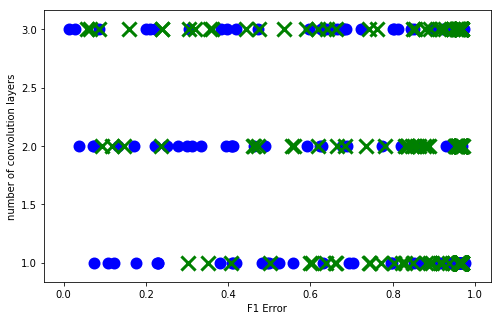

In [55]:
plt.figure(figsize=(8,5))

plt.scatter(cnn_errors_easy, all_features_easy.cnn_filters_length, c='b', alpha=alpha, s=size, linewidth=linewidth)
plt.scatter(cnn_errors_full, all_features_full.cnn_filters_length, c='g', alpha=alpha, s=2.5*size, marker='x', linewidth=linewidth)

plt.ylabel('number of convolution layers')
plt.xlabel('F1 Error')

# Three convolutional laters may provide too much capacity for the more simple dataset. The more complicated dataset 
# needs the additional capacity of three layers to perform well in the test dataset. Both datasets do not perform 
# well with a single convolutional layer.

# CNN kernel length

Text(0.5,0,'F1 Error')

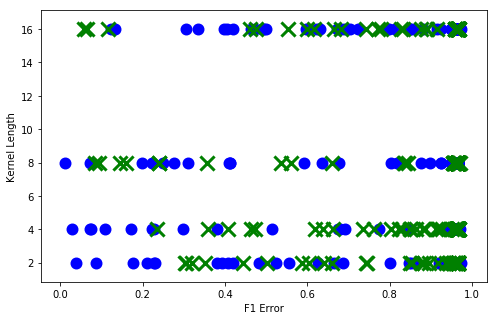

In [56]:
plt.figure(figsize=(8,5))

plt.scatter(cnn_errors_easy, all_features_easy.cnn_kernel_length, c='b', alpha=alpha, s=size, linewidth=linewidth)
plt.scatter(cnn_errors_full, all_features_full.cnn_kernel_length, c='g', alpha=alpha, s=2.5*size, marker='x', linewidth=linewidth)

plt.ylabel('Kernel Length')
plt.xlabel('F1 Error')

# Similar to the number of convolutional layers, the more difficult dataset needs the additional capacity of kernels of length
# 16 or 8. The simple dataset's performance degrades after a kernel length of 8.

# CNN Pool size length

Text(0.5,0,'F1 Error')

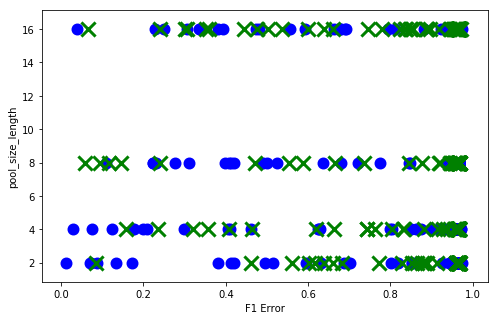

In [57]:
plt.figure(figsize=(8,5))

plt.scatter(cnn_errors_easy, all_features_easy.pool_size_length, c='b', alpha=alpha, s=size, linewidth=linewidth)
plt.scatter(cnn_errors_full, all_features_full.pool_size_length, c='g', alpha=alpha, s=2.5*size, marker='x', linewidth=linewidth)

plt.ylabel('pool_size_length')
plt.xlabel('F1 Error')

# Larger pooling lengths are better.

# Normalizer and Scaler

Text(0.5,0,'F1 Error')

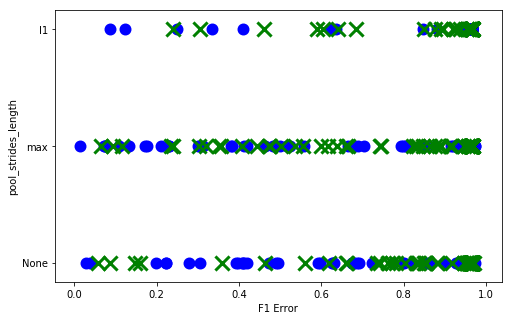

In [59]:
plt.figure(figsize=(8,5))

plt.scatter(cnn_errors_easy, all_features_easy.normalizer, c='b', alpha=alpha, s=size, linewidth=linewidth)
plt.scatter(cnn_errors_full, all_features_full.normalizer, c='g', alpha=alpha, s=2.5*size, marker='x', linewidth=linewidth)

plt.ylabel('pool_strides_length')
plt.xlabel('F1 Error')

Text(0.5,0,'F1 Error')

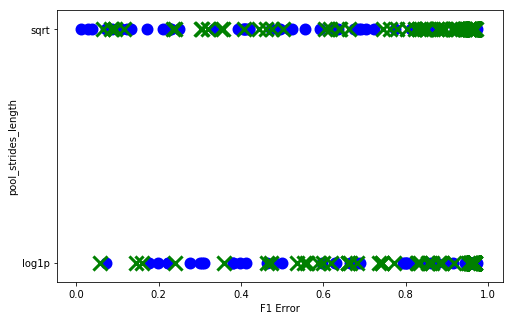

In [60]:
plt.figure(figsize=(8,5))

plt.scatter(cnn_errors_easy, all_features_easy.scaling, c='b', alpha=alpha, s=size, linewidth=linewidth)
plt.scatter(cnn_errors_full, all_features_full.scaling, c='g', alpha=alpha, s=2.5*size, marker='x', linewidth=linewidth)

plt.ylabel('pool_strides_length')
plt.xlabel('F1 Error')

Text(0.5,0,'F1 Error')

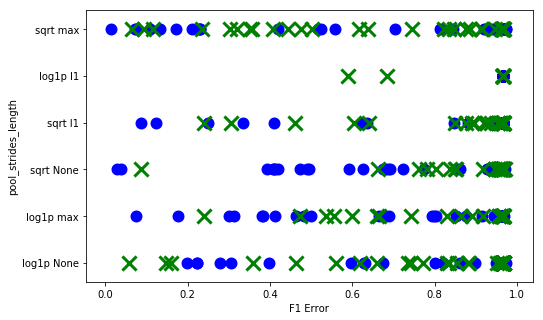

In [61]:
plt.figure(figsize=(8,5))

plt.scatter(cnn_errors_easy, [x+' '+y for x, y in zip(all_features_easy.scaling, all_features_easy.normalizer)], c='b', alpha=alpha, s=size, linewidth=linewidth)
plt.scatter(cnn_errors_full, [x+' '+y for x, y in zip(all_features_full.scaling, all_features_full.normalizer)], c='g', alpha=alpha, s=2.5*size, marker='x', linewidth=linewidth)

plt.ylabel('pool_strides_length')
plt.xlabel('F1 Error')

# Again, L1 normalization performs poorly. Interestingly the more difficult dataset performs well with sqrt-max or 
# log1p-None scaling. This may be because these transforms preserve the most useful structure in the data.